## RNN
### 영화 리뷰 감정 분석&  Seq2Seq기계번역

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
C:\Users\woojung\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
vocab_size = 256  # 총 아스키 코드 개수
x_ = list(map(ord, "hello"))  # 아스키 코드 리스트로 변환
y_ = list(map(ord, "hola"))   # 아스키 코드 리스트로 변환
print("hello -> ", x_)
print("hola  -> ", y_)

hello ->  [104, 101, 108, 108, 111]
hola  ->  [104, 111, 108, 97]


In [3]:
x = torch.LongTensor(x_)
y = torch.LongTensor(y_)

In [4]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.n_layers = 1
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.encoder = nn.GRU(hidden_size, hidden_size)
        self.decoder = nn.GRU(hidden_size, hidden_size)
        self.project = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs, targets):
        # 인코더에 들어갈 입력
        initial_state = self._init_state()
        embedding = self.embedding(inputs).unsqueeze(1)
        # embedding = [seq_len, batch_size, embedding_size]
        
        # 인코더 (Encoder)
        encoder_output, encoder_state = self.encoder(embedding, initial_state)
        # encoder_output = [seq_len, batch_size, hidden_size]
        # encoder_state  = [n_layers, seq_len, hidden_size]

        # 디코더에 들어갈 입력
        decoder_state = encoder_state
        decoder_input = torch.LongTensor([0])
        
        # 디코더 (Decoder)
        outputs = []
        
        for i in range(targets.size()[0]):
            decoder_input = self.embedding(decoder_input).unsqueeze(1)
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)
            projection = self.project(decoder_output)
            outputs.append(projection)
            
            #티처 포싱(Teacher Forcing) 사용
            decoder_input = torch.LongTensor([targets[i]])

        outputs = torch.stack(outputs).squeeze()
        return outputs
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()

In [5]:
seq2seq = Seq2Seq(vocab_size, 16)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=1e-3)

In [7]:
log = []
for i in range(1000):
    prediction = seq2seq(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data
    log.append(loss_val)
    if i % 100 == 0:
        print("\n 반복:%d 오차: %s" % (i, loss_val.item()))
        _, top1 = prediction.data.topk(1, 1)
        print([chr(c) for c in top1.squeeze().numpy().tolist()])


 반복:0 오차: 5.571754455566406
['ª', ')', '\x89', '\x89']

 반복:100 오차: 2.0917797088623047
['o', 'o', 'l', 'a']

 반복:200 오차: 0.5359830856323242
['h', 'o', 'l', 'a']

 반복:300 오차: 0.24439197778701782
['h', 'o', 'l', 'a']

 반복:400 오차: 0.1459803283214569
['h', 'o', 'l', 'a']

 반복:500 오차: 0.10094969719648361
['h', 'o', 'l', 'a']

 반복:600 오차: 0.07553713023662567
['h', 'o', 'l', 'a']

 반복:700 오차: 0.05930524319410324
['h', 'o', 'l', 'a']

 반복:800 오차: 0.048143308609724045
['h', 'o', 'l', 'a']

 반복:900 오차: 0.04003704711794853
['h', 'o', 'l', 'a']


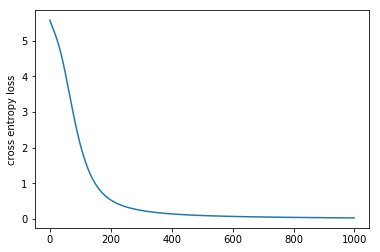

In [8]:
plt.plot(log)
plt.ylabel('cross entropy loss')
plt.show()